In [1]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!ls -a ~/.kaggle

.  ..  kaggle.json


In [2]:
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [3]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
from tensorflow.keras import layers
import time
from tqdm import tqdm

from IPython import display

In [4]:
path = '/content/img_align_celeba/img_align_celeba'
images = [] # X
# Note that we dont need Y :)

for image_name in tqdm(os.listdir(path)[0:50000]):
  img = cv2.imread(os.path.join(path, image_name))
  img = cv2.resize(img,(64,64))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  images.append(img)

100%|██████████| 50000/50000 [00:35<00:00, 1428.50it/s]


In [5]:
images = np.array(images)
train_images = images.reshape(images.shape[0], 64, 64, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
generator_model = tf.keras.Sequential()
generator_model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(100,)))
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Reshape((8, 8, 128)))
assert generator_model.output_shape == (None, 8, 8, 128)  # Note: None is the batch size

generator_model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
assert generator_model.output_shape == (None, 8, 8, 64)
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator_model.output_shape == (None, 16, 16, 32)
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator_model.output_shape == (None, 32, 32, 32)
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
assert generator_model.output_shape == (None, 64, 64, 3)

In [9]:
discriminator_model= tf.keras.Sequential()
discriminator_model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[64, 64, 3]))
discriminator_model.add(layers.LeakyReLU())
discriminator_model.add(layers.Dropout(0.3))

discriminator_model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator_model.add(layers.LeakyReLU())
discriminator_model.add(layers.Dropout(0.3))

discriminator_model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
discriminator_model.add(layers.LeakyReLU())
discriminator_model.add(layers.Dropout(0.3))

discriminator_model.add(layers.Flatten())
discriminator_model.add(layers.Dense(1))

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 9

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_model,
                                 discriminator=discriminator_model)

In [16]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator_model(noise, training=True)

      real_output = discriminator_model(images, training=True)
      fake_output = discriminator_model(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in tqdm(dataset):
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator_model,epoch + 1,seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator_model,
                           epochs,
                           seed)

In [18]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow((np.array(predictions[i, :, :, :] * 127.5 ) + 127.5 ).astype('uint8'))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

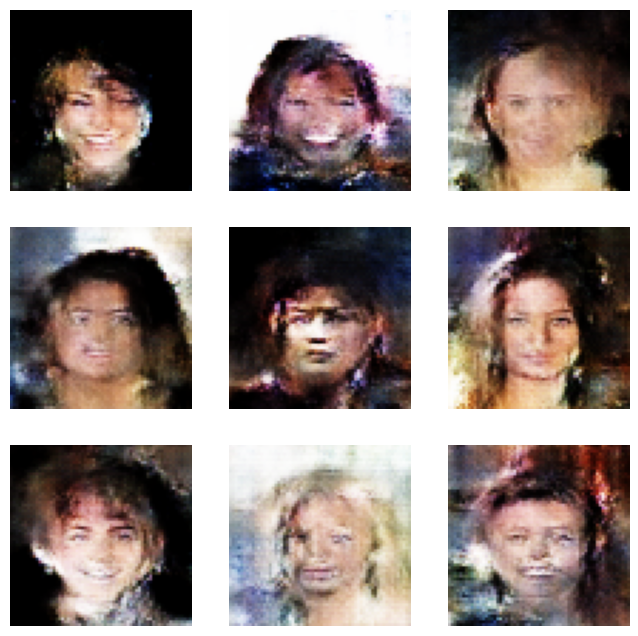

In [19]:
train(train_dataset, EPOCHS)

In [20]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

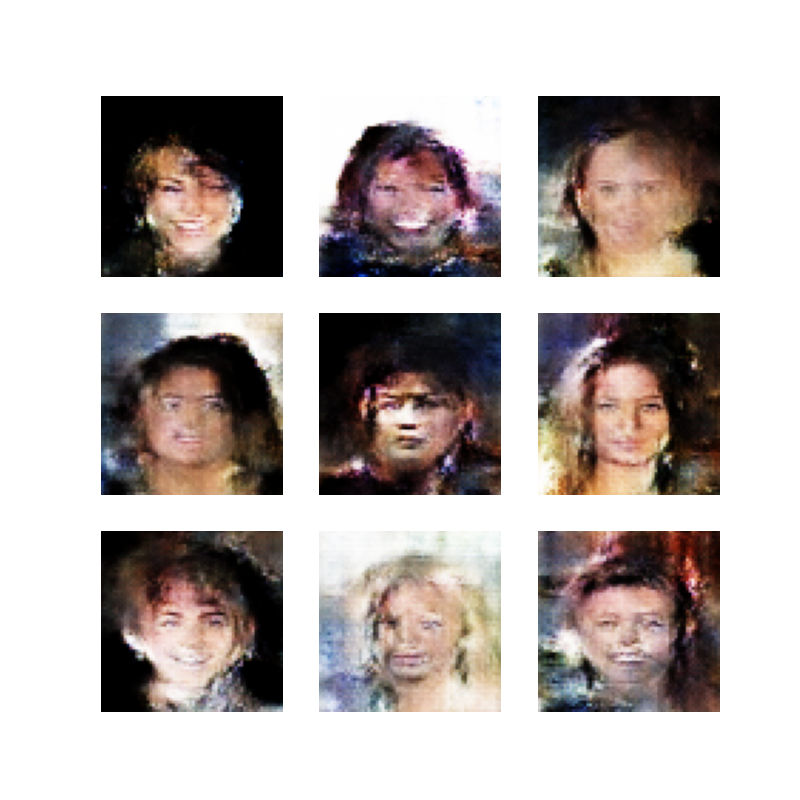

In [21]:
display_image(EPOCHS)

In [22]:
anim_file = 'celeb-a.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-22-4e55d99424c4>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-22-4e55d99424c4>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
